<a href="https://colab.research.google.com/github/RzTaleh/Data/blob/main/GHImax_Data_collection_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [131]:
# STEP 1: Install dependencies
!pip install astral xarray pandas matplotlib --quiet

In [305]:
# STEP 2: Upload your NetCDF irradiance file
from google.colab import files
uploaded = files.upload()

Saving 977692c95d2d8cc643831f4d2b71ca39.grib to 977692c95d2d8cc643831f4d2b71ca39.grib


In [306]:
# STEP 3: Load irradiance data
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt


In [307]:
file_path = list(uploaded.keys())[0]
ds = xr.open_dataset(file_path)

# Select ssrd and average over lat/lon
ssrd = ds['ssrd'].mean(dim=["latitude", "longitude"])
df = ssrd.to_dataframe().reset_index()

/usr/local/lib/python3.11/dist-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


In [308]:
# STEP 4: Convert to W/m² (J/m² per day → W/m² average)
df['time'] = pd.to_datetime(df['valid_time'])
df['irradiance'] = df['ssrd'] / 3600  # average W/m² over 24h


In [309]:
# STEP 5: Add sunrise/sunset times
from astral import LocationInfo
from astral.sun import sun
from datetime import date, timedelta

In [310]:
# Location coordinates
city = LocationInfo(name="Custom", region="World", timezone="UTC", latitude=40.5, longitude=45.5)

# Generate sunrise/sunset times for each day
sun_times = []
for d in df['time'].dt.date.unique():
    s = sun(city.observer, date=d)
    sun_times.append({
        'date': pd.to_datetime(d),
        'sunrise': s['sunrise'],
        'sunset': s['sunset']
    })

df_sun = pd.DataFrame(sun_times)

In [311]:
# STEP 6: Merge irradiance with sunrise/sunset info
df['date'] = df['time'].dt.normalize()
df_merged = pd.merge(df, df_sun, how='left', left_on='date', right_on='date')


In [312]:
# Ensure 'time' column is timezone-aware in UTC
df_merged['time'] = df_merged['time'].dt.tz_localize('UTC')

# Now compare safely (sunrise/sunset are already in UTC)
df_day = df_merged[
    (df_merged['time'] >= df_merged['sunrise']) &
    (df_merged['time'] <= df_merged['sunset'])
]

In [313]:
# STEP 8: Compute daily peak irradiance (during day only)
df_day['day'] = df_day['time'].dt.date
daily_peaks = df_day.groupby('day')['irradiance'].max()


/tmp/ipython-input-313-2604434240.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_day['day'] = df_day['time'].dt.date


In [314]:
# STEP 9: Compute the average of daily peak irradiance values
average_peak_irradiance = daily_peaks.mean()

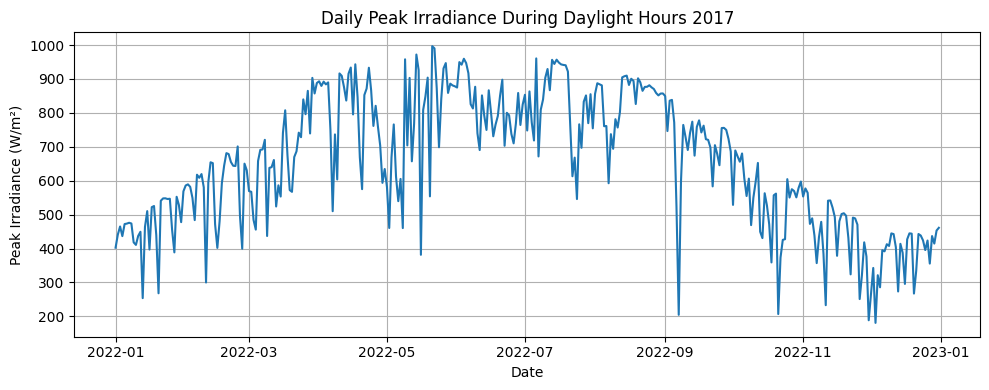

In [315]:
# STEP 11: Plot
plt.figure(figsize=(10, 4))
daily_peaks.plot()
plt.title("Daily Peak Irradiance During Daylight Hours 2017")
plt.xlabel("Date")
plt.ylabel("Peak Irradiance (W/m²)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [316]:
# STEP 10: Output
print(f"☀️ Average peak irradiance during daylight hours: {average_peak_irradiance:.2f} W/m²")
print(f"📆 Valid days: {len(daily_peaks)}")

☀️ Average peak irradiance during daylight hours: 653.83 W/m²
📆 Valid days: 366
